In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta


In [2]:
df_to_forecasting = pd.read_csv(r'../data/updated_data_ind/eth_ind.csv')

In [3]:
df_eth = pd.read_csv(r'../data/cryptoInd/eth_ind.csv')
close = df_eth['close']
df_eth.drop('close', axis = 1, inplace = True)
df_eth['close'] = close

close = df_to_forecasting['close']
df_to_forecasting.drop('close', axis = 1, inplace = True)
df_to_forecasting['close'] = close

In [4]:
df_eth.head(10)

,Date,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
0,2017-12-12,651.431030,504.493988,657.317993,522.286011,5.179830e+09,471.845540,414.242651,477.317365,35.758695,...,53.550952,50.810936,2.740015,77.716476,52.501418,75.380271,65.096302,94.080002,2664.110107,651.431030
1,2017-12-13,702.767029,597.797974,747.992981,644.906006,4.524540e+09,487.169875,422.486204,505.498573,37.572042,...,66.384639,53.925677,12.458962,80.325519,77.951726,93.835496,78.015952,93.418999,2662.850098,702.767029
2,2017-12-14,695.815979,664.989014,753.120972,700.593994,3.821580e+09,505.056073,430.078698,529.288249,39.294351,...,75.128503,58.166242,16.962261,78.983905,91.769196,88.528524,85.914764,93.478996,2652.010010,695.815979
3,2017-12-15,684.447998,621.060974,697.132019,696.375977,2.758710e+09,520.878339,436.953544,548.683217,39.813820,...,80.216096,62.576213,17.639883,76.738053,100.463194,82.073997,88.146006,93.929001,2675.810059,684.447998
4,2017-12-16,696.208984,680.786011,718.385010,686.192017,2.165690e+09,536.189604,443.776056,567.123938,40.472299,...,84.226156,66.906201,17.319955,77.448833,108.217207,79.177363,83.259961,93.929001,2675.810059,696.208984
5,2017-12-17,719.974976,696.237000,735.825012,696.237000,2.147390e+09,553.291335,450.858079,586.230318,41.226010,...,88.303962,71.185753,17.118208,78.848140,115.401701,77.966751,79.739370,93.929001,2675.810059,719.974976
6,2017-12-18,794.645020,689.231018,803.927979,721.731995,3.249230e+09,575.210803,459.452753,612.282156,42.404917,...,96.449095,76.238422,20.210674,82.502934,127.321766,83.564367,80.236160,93.519997,2690.159912,794.645020
7,2017-12-19,826.822998,785.341980,881.943970,793.901001,4.096550e+09,598.985402,468.413003,639.099761,43.926087,...,104.298380,81.850413,22.447966,83.795701,138.315166,84.151665,81.894261,93.027000,2681.469971,826.822998
8,2017-12-20,819.085999,756.004028,845.062012,827.515991,3.969940e+09,622.705735,476.762360,661.598041,44.703767,...,108.642322,87.208795,21.433527,82.230518,143.423627,80.848991,82.855007,92.890999,2679.250000,819.085999
9,2017-12-21,821.062988,792.689026,880.543030,820.236023,3.569060e+09,648.870734,484.769351,681.531159,45.637520,...,110.965315,91.960099,19.005216,82.320925,141.409536,72.010593,79.003750,92.862000,2684.570068,821.062988


In [5]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_eth['Date'], y=df_eth['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [6]:
inicial_date = '2021-04-14'
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_to_forecasting['Date'] = pd.to_datetime(df_to_forecasting['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_eth = df_eth[df_eth['Date'] >= inicial_date]
df_to_forecasting = df_to_forecasting[df_to_forecasting['Date'] >= inicial_date]

# Scaling

In [7]:
df_eth.set_index('Date', inplace=True)
scaled_df = df_eth.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_eth)
scaled_df = pd.DataFrame(scaled_feat, index = df_eth.index, columns=df_eth.columns)
scaled_df.head()

,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,bb_low,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,0.214111,0.191654,0.200572,0.169678,0.372801,0.050500,0.000000,0.054282,0.287665,0.084415,...,0.586963,0.575674,0.778597,0.818571,0.108643,0.886572,0.852352,0.168520,0.084006,0.214111
2021-04-15,0.241887,0.233296,0.231534,0.214882,0.330887,0.065747,0.002640,0.073979,0.348096,0.080515,...,0.612396,0.590320,0.808239,0.854318,0.149268,0.955346,0.912771,0.163907,0.146390,0.241887
2021-04-16,0.213066,0.202985,0.232611,0.241526,0.380551,0.077286,0.005165,0.087000,0.374507,0.086191,...,0.621148,0.604038,0.800619,0.756353,0.161040,0.887113,0.927864,0.157812,0.166908,0.213066
2021-04-17,0.184285,0.207970,0.216187,0.212880,0.331197,0.082404,0.007575,0.094185,0.399157,0.087715,...,0.616741,0.614005,0.769810,0.667490,0.168448,0.723879,0.870575,0.157812,0.166908,0.184285
2021-04-18,0.148658,0.101037,0.172999,0.185256,0.566561,0.087701,0.009845,0.095263,0.344555,0.097294,...,0.599952,0.618139,0.721907,0.569169,0.158518,0.537973,0.723605,0.157812,0.166908,0.148658


# Correlation Matrix

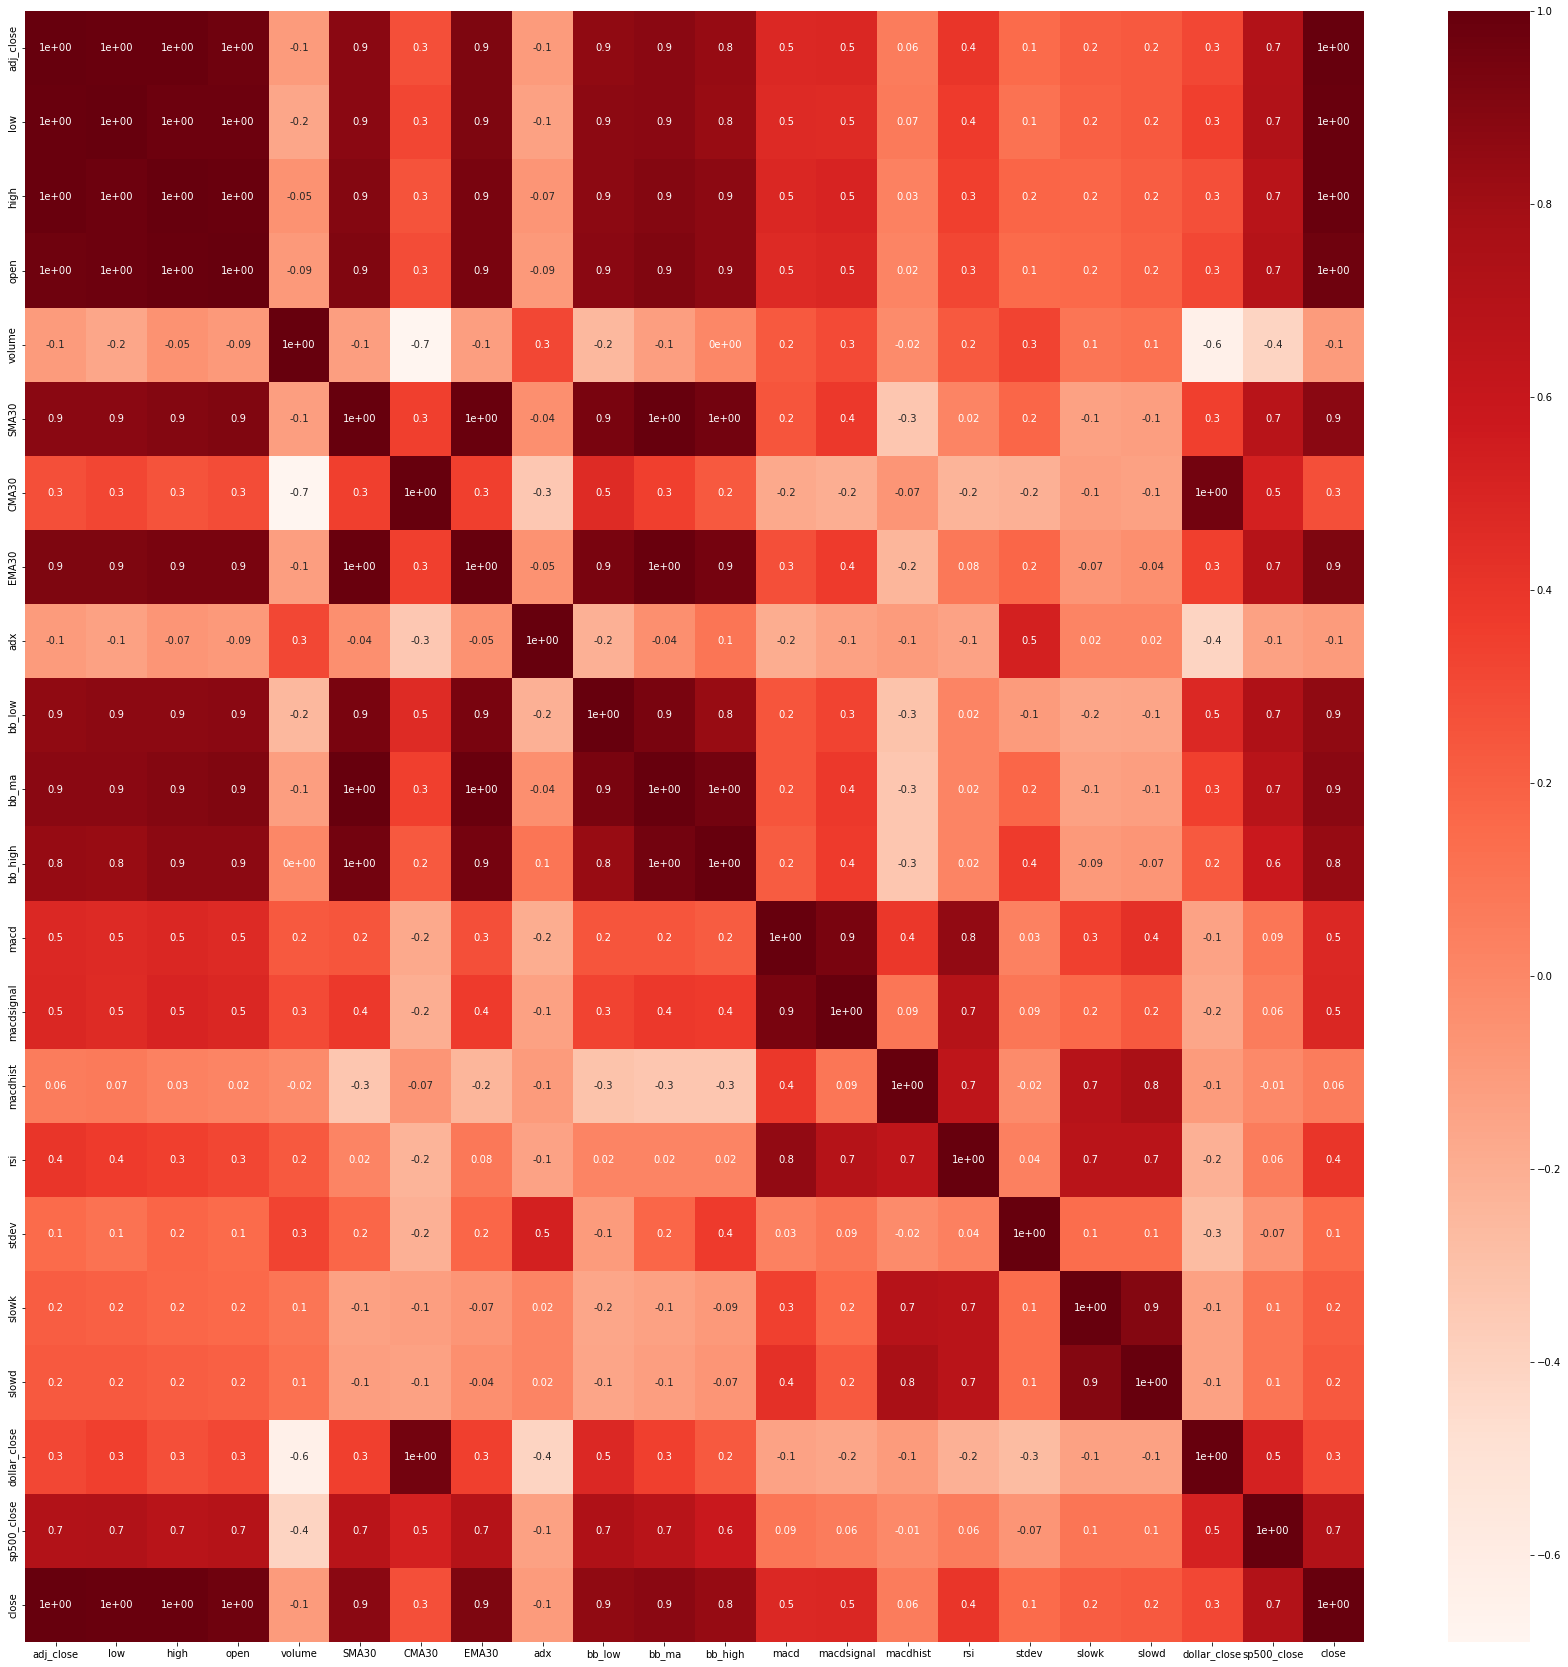

In [8]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [9]:
scaled_df.columns

Index(['adj_close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30', 'EMA30',
       'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal', 'macdhist',
       'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close', 'sp500_close',
       'close'],
      dtype='object')

In [10]:
df_eth.drop(['low', 'adj_close', 'open','SMA30','EMA30','CMA30',
 'bb_ma', 'bb_high','dollar_close'], axis=1, inplace=True)

df_to_forecasting.drop(['low', 'adj_close', 'open','SMA30','EMA30','CMA30',
 'bb_ma', 'bb_high','dollar_close'], axis=1, inplace=True)

## TimeBaseCV

In [11]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

# Models

## Function to Apply the Models

In [12]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [13]:
def forecasting(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    fit = model.fit(finaldf_train_x, finaldf_train_y)
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    return yhat

In [19]:
def show_results(df_results, df,objetive ='close',train_period_split=100,test_period_split=5, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []
            y_pred_test = forecasting(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results         
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train['close']
            X_pred_test = X_test.copy()
            X_test['close'] = y_test
            X_pred_test['close'] = y_pred_test

            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results
        
    

## Random Forest

In [20]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mse','mae'])
show_results(df, df_eth,'close',100,5, rf_se, rf_ae)

,MAE,MSE,RMSE,R2
mse,0.017124,0.000458,0.021401,0.005315
mae,0.018154,0.000513,0.022647,-0.113934


In [21]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['5','20', '50'])
show_results(df, df_eth,'close',100,5,rf_5, rf_20,rf_50)

,MAE,MSE,RMSE,R2
5,0.017168,0.000484,0.02199,-0.050192
20,0.017124,0.000458,0.021401,0.005315
50,0.017124,0.000458,0.021401,0.005315


In [22]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_eth,'close',100,5,rf_auto, rf_sqrt,rf_log2)

,MAE,MSE,RMSE,R2
auto,0.017124,0.000458,0.021401,0.005315
sqrt,0.014664,0.000248,0.015761,0.460525
log2,0.014664,0.000248,0.015761,0.460525


In [23]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, max_features='sqrt', n_estimators=50)
rf_20 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, max_features='sqrt',n_estimators=100)
rf_30 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20,max_features='sqrt', n_estimators=150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['50','100', '150'])
show_results(df, df_eth,'close',100,5,rf_10, rf_20,rf_30)

,MAE,MSE,RMSE,R2
50,0.014716,0.000298,0.01725,0.353778
100,0.014664,0.000248,0.015761,0.460525
150,0.013617,0.000253,0.01591,0.450273


In [24]:
rf_final = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20, max_features='sqrt', n_estimators=100)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_eth,'close',100,5, rf_final)

,MAE,MSE,RMSE,R2
final,0.014664,0.000248,0.015761,0.460525


## Gradient Boost

In [25]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae')
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mae','mse'])
show_results(df, df_eth,'close',100,5,gb_mae, gb_mse)

,MAE,MSE,RMSE,R2
mae,0.024837,0.000878,0.02963,-0.906774
mse,0.019112,0.000678,0.026042,-0.472944


In [26]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 150)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 200)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 250)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['150','200', '250'])
show_results(df, df_eth,'close',100,5,gb_50, gb_100, gb_150)

,MAE,MSE,RMSE,R2
150,0.019075,0.000663,0.025751,-0.440114
200,0.019204,0.000666,0.025798,-0.445468
250,0.019233,0.00067,0.025885,-0.455174


In [27]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_eth,'close',100,5,gb_auto, gb_sqrt, gb_log2)

,MAE,MSE,RMSE,R2
auto,0.025436,0.000876,0.029601,-0.903025
sqrt,0.018918,0.0004,0.020002,0.131117
log2,0.018918,0.0004,0.020002,0.131117


In [28]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['final'])
show_results(df, df_eth,'close',100,5,gb_final)

,MAE,MSE,RMSE,R2
final,0.018918,0.0004,0.020002,0.131117


## Neural Nerworks

In [29]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(25,25), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['2525','10101010', '10'])
show_results(df, df_eth,'close',100,5,nn_2525, nn_10101010, nn_10)

,MAE,MSE,RMSE,R2
2525,0.08644,0.008015,0.089524,-16.406169
10101010,0.05484,0.00329,0.05736,-6.145683
10,0.277978,0.080609,0.283917,-174.068356


In [30]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, df_eth,'close',100,5,nn_identity, nn_logistic, nn_tanh, nn_relu)

,MAE,MSE,RMSE,R2
identity,0.087106,0.008185,0.09047,-16.775972
logistic,0.060467,0.004118,0.064175,-7.944551
tanh,0.028391,0.000981,0.031316,-1.129942
relu,0.05484,0.00329,0.05736,-6.145683


In [31]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, df_eth,'close',100,5,nn_lbfgs, nn_sgd, nn_adam)

,MAE,MSE,RMSE,R2
lbfgs,0.017977,0.000489,0.022113,-0.062032
sgd,0.116072,0.01398,0.118237,-29.362204
adam,0.028391,0.000981,0.031316,-1.129942


In [32]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['constant','invscaling', 'adaptive'])
show_results(df, df_eth,'close',100,5,nn_constant, nn_invscaling, nn_adam)

,MAE,MSE,RMSE,R2
constant,0.017977,0.000489,0.022113,-0.062032
invscaling,0.017977,0.000489,0.022113,-0.062032
adaptive,0.028391,0.000981,0.031316,-1.129942


In [33]:
nn_final = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['final'])
show_results(df, df_eth,'close',100,5,nn_final)

,MAE,MSE,RMSE,R2
final,0.017977,0.000489,0.022113,-0.062032


## XGBoost

In [34]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error')
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['mae','mse'])
show_results(df, df_eth,'close',100,5,xgb_mae, xgb_mse)

[20:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:49:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:49:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could b

,MAE,MSE,RMSE,R2
mae,0.014286,0.000358,0.018929,0.221857
mse,0.014286,0.000358,0.018929,0.221857


In [35]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)
xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)
xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['gbtree','gblinear','dart'])

show_results(df, df_eth,'close',100,5,xgb_gbtree, xgb_gblinear,xgb_dart )

,MAE,MSE,RMSE,R2
gbtree,0.014286,0.000358,0.018929,0.221857
gblinear,0.016921,0.000401,0.020034,0.128291
dart,0.014286,0.000358,0.018929,0.221859


In [36]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = True)
xgb_false = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])

show_results(df, df_eth,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.014286,0.000358,0.018929,0.221859
False,0.014286,0.000358,0.018929,0.221859


In [37]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)
xgb_true = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_eth,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.014286,0.000358,0.018929,0.221859
False,0.014286,0.000358,0.018929,0.221859


In [38]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.05)
xgb_01 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.1)
xgb_03 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)
xgb_05 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.5)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df, df_eth,'close',100,5, xgb_005,xgb_01, xgb_03, xgb_05 )

,MAE,MSE,RMSE,R2
"0,05",0.01561,0.000421,0.020509,0.086478
"0,1",0.017301,0.000576,0.024008,-0.251849
"0,3",0.014286,0.000358,0.018929,0.221859
"0,5",0.02114,0.000479,0.021888,-0.040531


In [39]:
xgb_150 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 150, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)
xgb_200 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 200, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)
xgb_250 = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 250, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['150', '200', '250'])
show_results(df, df_eth,'close',100,5, xgb_150,xgb_200, xgb_250)

,MAE,MSE,RMSE,R2
150,0.014286,0.000358,0.018929,0.221859
200,0.014286,0.000358,0.018929,0.221859
250,0.014286,0.000358,0.018929,0.221859


In [40]:
xgb_final = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_eth,'close',100,5, xgb_final)

,MAE,MSE,RMSE,R2
final,0.014286,0.000358,0.018929,0.221859


# Results

In [41]:
df_to_forecasting.tail()

,Date,high,volume,adx,bb_low,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,sp500_close,close
1604,2022-05-04,2956.686768,1.818675e+10,23.297357,2716.365636,-68.408144,-65.107611,-3.300534,49.024054,91.468769,57.287499,42.914713,4300.169922,2940.644775
1605,2022-05-05,2948.960693,2.264293e+10,23.219570,2706.921134,-74.230131,-66.932115,-7.298016,41.848961,85.239929,45.517031,47.567823,4146.870117,2749.213135
1606,2022-05-06,2754.837646,2.102760e+10,23.550984,2675.733338,-82.271900,-70.000072,-12.271828,40.068872,91.083795,42.180776,48.328435,4123.339844,2694.979736
1607,2022-05-07,2696.652832,1.336928e+10,24.148743,2632.676912,-92.332375,-74.466532,-17.865843,38.179568,101.653919,14.592630,34.096813,4123.339844,2636.093018
1608,2022-05-08,2637.854004,2.095508e+10,25.238778,2563.530753,-107.443379,-81.061902,-26.381478,35.057397,122.699321,10.788136,22.520514,4123.339844,2532.283691


In [42]:
forecasting(rf_final,df_to_forecasting,2)

array([[2637.53494995],
       [2528.23868164]])

In [43]:
forecasting(nn_final,df_to_forecasting,2)

array([[3149.44727977],
       [3149.44727977]])

In [46]:
forecasting(gb_final,df_to_forecasting,2)

array([[2674.29575996],
       [2507.62122543]])

In [47]:
forecasting(xgb_final,df_to_forecasting,2)

array([[2551.6355],
       [2499.0273]], dtype=float32)